# ライブラリのインポート:


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.utils import plot_model
from keras import backend as K


- pandas: データフレーム処理のためのライブラリ。
- numpy: 数値演算のためのライブラリ。
- matplotlib.pyplot: データの可視化のためのライブラリ。
- train_test_split: データをトレーニングセットとテストセットに分割するための関数。
- StandardScaler: データの標準化のためのクラス。
- OneHotEncoder: カテゴリカル変数のワンホットエンコーディングのためのクラス。
- ColumnTransformer: 異なる前処理ステップを複数の特徴量セットに適用するためのクラス。
- Pipeline: データの前処理ステップを組み合わせるためのクラス。
- Sequential, Dense, Dropout, BatchNormalization, LeakyReLU: Kerasのニューラルネ- ットワークモデルを構築するためのクラス。
- to_categorical: クラスラベルをバイナリ行列に変換するためのユーティリティ関数。
- Adam: 最適化アルゴリズム Adam を実装したクラス。
- EarlyStopping, LearningRateScheduler: コールバック関数。

In [30]:
train = pd.read_csv('./we-are-the-best/yabindra-data/newdata/train.csv')
test = pd.read_csv('./we-are-the-best/yabindra-data/newdata/test.csv')


# データのクリニック

- トレーニングデータとテストデータの CSV ファイルを読み込む。

In [31]:
train.drop('ID', axis=1, inplace=True)


- 'ID' 列を削除して、余分な情報を取り除く。

In [32]:
# 欠損値のランダムな値で埋める関数
def fill_na_random(df):
    columns_to_fill = df.columns[df.isna().any()].tolist()

    for column in columns_to_fill:
        non_nan_values = df[column].dropna()
        nan_count = df[column].isna().sum()
        random_values = np.random.choice(non_nan_values, nan_count)
        df[column][df[column].isna()] = random_values

    return df

In [33]:
# 訓練データに対して欠損値のランダムな値で埋める
train = fill_na_random(train)

# テストデータに対して欠損値のランダムな値で埋める
test = fill_na_random(test)

/var/folders/71/9hsrmxwx6nz4s91n_m1rk0lh0000gn/T/ipykernel_14602/1331607019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df[column].isna()] = random_values
/var/folders/71/9hsrmxwx6nz4s91n_m1rk0lh0000gn/T/ipykernel_14602/1331607019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df[column].isna()] = random_values
/var/folders/71/9hsrmxwx6nz4s91n_m1rk0lh0000gn/T/ipykernel_14602/1331607019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

- 損値をランダムな値で埋める関数。トレーニングデータとテストデータのそれぞれに対して適用されます。

In [34]:
# 欠損値の処理
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

もしもデータが入っていなかったら 0 

# 特徴量エンジニアリング

In [35]:

def feature_engineering(data):
    data['Income_per_Alien'] = data['Income'] / (data['Alien'].replace(0, 1))  # Avoid division by zero
    data['Income_per_Alien'] = data['Income_per_Alien'].astype(int)

    data['TotalPower'] = data['SpacePort'] + data['PowerPlant']
    data['HighIncome'] = (data['Income'] > data['Income'].median()).astype(int)

    return data

In [36]:

train = feature_engineering(train)

## Income_per_Alien:

Alienごとの平均収入を計算します。Alienが存在しない場合（Alienが0の場合）、除算を避けるために1で置き換えます。
astype(int) により、小数点以下を切り捨てて整数型に変換されます。


## TotalPower (合計パワー):

'SpacePort' と 'PowerPlant' の合計パワーを計算します。

## HighIncome (高収入フラグ):

'Income' 列の中央値よりも高い収入の場合、1（True）に、それ以外の場合、0（False）に変換します

In [37]:
column = train.columns.tolist()
print(column)

['Medical', 'PowerPlant', 'Natural', 'SpacePort', 'Alien', 'Income', 'Education', 'Module', 'PopulationDensity', 'Murder', 'Purpose', 'Meteor', 'value', 'Income_per_Alien', 'TotalPower', 'HighIncome']


In [38]:
# Data splitting
train_data, validation_data = train_test_split(train, test_size=0.2, random_state=42)


`train` データセットをトレーニングデータと検証データに分割します。`test_size=0.2` は、検証データの割合を示しており、`random_state=42` はランダムな分割の再現性を担保しています。


### 特徴量の定義

In [39]:
# 特徴量の定義
features = ['Medical', 'PowerPlant', 'Natural', 'SpacePort', 'Alien', 'Income', 'Education', 'PopulationDensity', 'Murder', 'Module', 'Purpose']


### カテゴリカル特徴量


In [40]:
categorical_features = ['Module', 'Purpose']

###

In [41]:
# データを前処理するための関数
def preprocess_data(data, features, target_column='value'):
    if target_column in data.columns:
        X = data[features]
        y = data[target_column]

        # 数値とカテゴリカル特徴量の前処理器を定義
        numeric_features = X.columns.difference(categorical_features)
        
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # ColumnTransformerを使用して前処理器を組み合わせる
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

         # データを前処理
        X_preprocessed = preprocessor.fit_transform(X)

       # ラベルをカテゴリカルに変換
        label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'S': 4}
        y_numeric = y.map(label_mapping)
        y_binary = to_categorical(y_numeric, num_classes=5)

        return X_preprocessed, y_binary
    else:
        X = data[features]

        # 数値とカテゴリカル特徴量の前処理器を定義
        numeric_features = X.columns.difference(categorical_features)
        
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # ColumnTransformerを使用して前処理器を組み合わせる
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

       # データを前処理
        X_preprocessed = preprocessor.fit_transform(X)

        return X_preprocessed, None


In [42]:
#関数の呼び出し
X_train_scaled, y_train_binary = preprocess_data(train_data, features)
X_validation_scaled, y_validation_binary = preprocess_data(validation_data, features)
X_test_scaled, _ = preprocess_data(test, features)

# ニューラルネットワークモデルの構築

In [43]:
def build_nn_model(input_dim):
    model = Sequential()
    
    # Input layer
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Hidden layers
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


- この関数では、Sequential モデルを作成し、Dense レイヤーを使用して畳み込みニューラルネットワーク（CNN）を構築しています。
- ニューラルネットワークには、入力層、隠れ層、および出力層が含まれています。
- 各層では、活性化関数、正規化、およびドロップアウトが適用されています。
- 最後に、モデルをコンパイルして、最適化アルゴリズム、損失関数、および評価メトリクスを指定しています

In [ ]:
# Learning rate scheduling
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

- この関数は、学習率をスケジューリングするためのもので、ニューラルネットワークの学習中に動的に学習率を変更します。
- initial_lr は初期学習率を示しており、ここでは 0.001 と設定されています。
- drop は学習率をどれだけ減衰させるかを示しており、ここでは 0.5 と設定されています。
- epochs_drop は学習率を減衰させるエポックの間隔を示しています。10 エポックごとに学習率が減衰します。
- np.floor((1+epoch)/epochs_drop) は現在のエポック数を epochs_drop で割って小数点以下を切り捨てています。
- 学習率 lrate は、初期学習率を減衰率に基づいて計算され、各エポックごとに変化します。

In [ ]:
lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



- lr_scheduler は、学習率のスケジュールを設定するための LearningRateScheduler コールバックです。このコールバックは、各エポックの最初に step_decay 関数を呼び出し、その結果を学習率に適用します。これにより、学習率が動的に変化し、最適な学習率スケジュールを実現できます。

- early_stopping は、訓練が収束したかどうかを監視し、早期に訓練を停止するためのコールバックです。monitor='val_loss' は検証データの損失を監視し、patience=10 は改善が見られない場合に、10エポック以上損失が改善されない場合に訓練を停止します。restore_best_weights=True は、最良の重みで訓練が停止した場合に、その時点のモデルの重みを復元する設定です。これにより、最も性能が良いモデルが保存されます

In [ ]:
nn_model = build_nn_model(X_train_scaled.shape[1])
model = nn_model.fit(X_train_scaled, y_train_binary, epochs=1, batch_size=64, validation_data=(X_validation_scaled, y_validation_binary), callbacks=[lr_scheduler, early_stopping])



125/125 [==============================] - 35s 154ms/step - loss: 1.8721 - accuracy: 0.3273 - val_loss: 1.3653 - val_accuracy: 0.3770 - lr: 0.0010


- nn_model = build_nn_model(X_train_scaled.shape[1]): ニューラルネットワークモデルを構築します。X_train_scaled.shape[1] は入力の次元数で、これはニューラルネットワークの最初の層の入力次元数として使用されます。

- nn_model.fit(): ニューラルネットワークを実際に訓練します。以下は各引数の説明です：

- X_train_scaled, y_train_binary: 訓練データの入力 (X_train_scaled) と対応するラベル (y_train_binary)。
- epochs=50: エポック数は 50 で、データ全体を 50 回処理します。
- batch_size=32: ミニバッチ学習を行い、各バッチのサイズは 32 です。
- validation_data=(X_validation_scaled, y_validation_binary): 検証データを指定し、各エポック終了後にモデルの性能を検証します。
- callbacks=[lr_scheduler, early_stopping]: コールバック関数として、学習率のスケジュール (lr_scheduler) と早期停止 (early_stopping) を使用します。これにより、動的な学習率調整と早期停止が実現されます。

## テストデータに対する予測

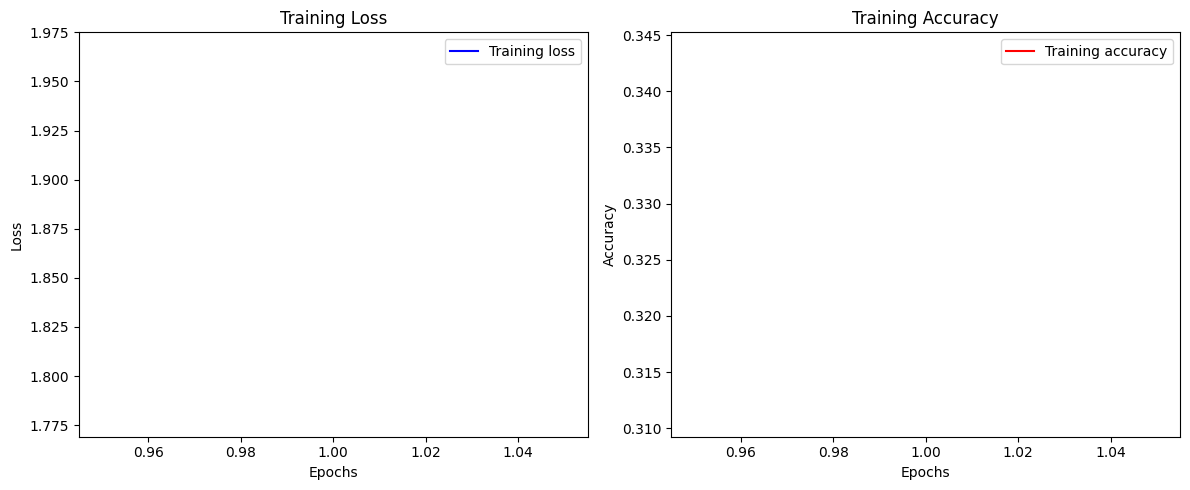

In [ ]:

# 損失値と精度の推移を取得
loss = model.history['loss']
accuracy = model.history['accuracy']

# グラフの描画
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# テストデータに対して予測を行う
y_test_probs = nn_model.predict(X_test_scaled)
y_test = np.argmax(y_test_probs, axis=1)

# 'ID' 列と予測値を含む DataFrame を作成する
submission_df = pd.DataFrame({'ID': test['ID'], 'value': y_test})

# 'value' 列の NaN 値を処理する
submission_df['value'] = submission_df['value'].map({0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'S'}).fillna('A')

# DataFrame を CSV ファイルに保存する
submission_df.to_csv('categorical.csv', index=False)
print("Submission saved to submission_nn_with_categorical.csv")


157/157 [==============================] - 6s 15ms/step
Submission saved to submission_nn_with_categorical.csv
